In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import Lasso
from sklearn.utils import resample
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, roc_curve, auc, confusion_matrix
from sklearn.model_selection import cross_val_score
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns

# random seed to ensure consistency
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

# import cohort 1
cohort_1 = pd.read_csv("AthleteTBIData.csv") # original file name

cohort_1_filtered = cohort_1[cohort_1["OrigiinalGroupID"].str.contains("post 6 hours", na=False)]

# preprocessing
cohort_1_filtered = cohort_1_filtered.drop(columns=['SampleID', 'OrigiinalGroupID'])
cohort_1_filtered.reset_index(drop=True, inplace=True)

# split dataset
X = cohort_1_filtered.drop(columns=['GroupNo'])  
y = cohort_1_filtered['GroupNo'].values  # Ensure y is a NumPy array

# standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# VAE
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim=10):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, latent_dim * 2)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
          
    nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim)
        )
    
    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def forward(self, x):
        h = self.encoder(x)
        mu, log_var = h.chunk(2, dim=1)
        z = self.reparameterize(mu, log_var)
        return self.decoder(z), mu, log_var

# Convert to PyTorch 
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)

input_dim = X.shape[1]
vae = VAE(input_dim, latent_dim=10)
optimizer = optim.Adam(vae.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

# Train VAE
epochs = 300
for epoch in range(epochs):
    optimizer.zero_grad()
    
    reconstructed, mu, log_var = vae(X_tensor)
    reconstruction_loss = loss_fn(reconstructed, X_tensor)
    kl_divergence = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    loss = reconstruction_loss + kl_divergence
    loss.backward()
    optimizer.step()

# generate 20 samples (identified through cross-validation optimization algorithm)
num_synthetic_samples = 20
fixed_z_sample = torch.randn((num_synthetic_samples, 10), generator=torch.Generator().manual_seed(seed))
synthetic_data = vae.decoder(fixed_z_sample).detach().numpy()

# add synthetic data to the original dataset
np.random.seed(seed)
y_extended = np.concatenate([y, np.random.choice(y, size=num_synthetic_samples)])
X_extended = np.vstack([X_scaled, synthetic_data])

# stratified sampling
X_train, X_test, y_train, y_test = train_test_split(X_extended, y_extended, test_size=0.2, random_state=seed, stratify=y_extended)

# LASSO
lasso = Lasso(alpha=0.1, random_state=seed)
lasso.fit(X_train, y_train)
selected_features = lasso.coef_ != 0
X_train_selected = X_train[:, selected_features]
X_test_selected = X_test[:, selected_features]

print(f"Number of selected features after Lasso: {np.sum(selected_features)}")

# apply PCA
n_components = 10
pca = PCA(n_components=n_components, random_state=seed)
X_train_pca = pca.fit_transform(X_train_selected)
X_test_pca = pca.transform(X_test_selected)

# train MLP
mlp_model = MLPClassifier(hidden_layer_sizes=(64, 32), activation='relu', max_iter=3000, 
                          alpha=0.8, solver='adam', random_state=seed, learning_rate_init=0.0001, verbose=True)
mlp_model.fit(X_train_pca, y_train)

# training
y_train_pred = mlp_model.predict(X_train_pca)
train_auc = roc_auc_score(y_train, mlp_model.predict_proba(X_train_pca)[:, 1])

# evaluate on test data
y_test_pred = mlp_model.predict(X_test_pca)
test_auc = roc_auc_score(y_test, mlp_model.predict_proba(X_test_pca)[:, 1])

# evaluation metrics for training and testing sets
print("\nTraining Classification Report:\n", classification_report(y_train, y_train_pred))
print(f'Training ROC AUC Score: {train_auc}')
print("\nTest Classification Report:\n", classification_report(y_test, y_test_pred))
print(f'Test ROC AUC Score: {test_auc}')


# cross-validation with StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
cross_val_auc = cross_val_score(mlp_model, X_train_pca, y_train, cv=stratified_kfold, scoring='roc_auc')
print(f"Cross-validated AUC: {cross_val_auc.mean():.4f}")




Number of selected features after Lasso: 20
Iteration 1, loss = 1.22544007
Iteration 2, loss = 1.22340422
Iteration 3, loss = 1.22138118
Iteration 4, loss = 1.21936921
Iteration 5, loss = 1.21736997
Iteration 6, loss = 1.21537646
Iteration 7, loss = 1.21338763
Iteration 8, loss = 1.21140680
Iteration 9, loss = 1.20943458
Iteration 10, loss = 1.20746938
Iteration 11, loss = 1.20551414
Iteration 12, loss = 1.20357218
Iteration 13, loss = 1.20162421
Iteration 14, loss = 1.19968668
Iteration 15, loss = 1.19776181
Iteration 16, loss = 1.19584975
Iteration 17, loss = 1.19394875
Iteration 18, loss = 1.19205525
Iteration 19, loss = 1.19017020
Iteration 20, loss = 1.18829376
Iteration 21, loss = 1.18642736
Iteration 22, loss = 1.18456935
Iteration 23, loss = 1.18271947
Iteration 24, loss = 1.18087764
Iteration 25, loss = 1.17904439
Iteration 26, loss = 1.17722146
Iteration 27, loss = 1.17540802
Iteration 28, loss = 1.17360821
Iteration 29, loss = 1.17182505
Iteration 30, loss = 1.17006114
Itera

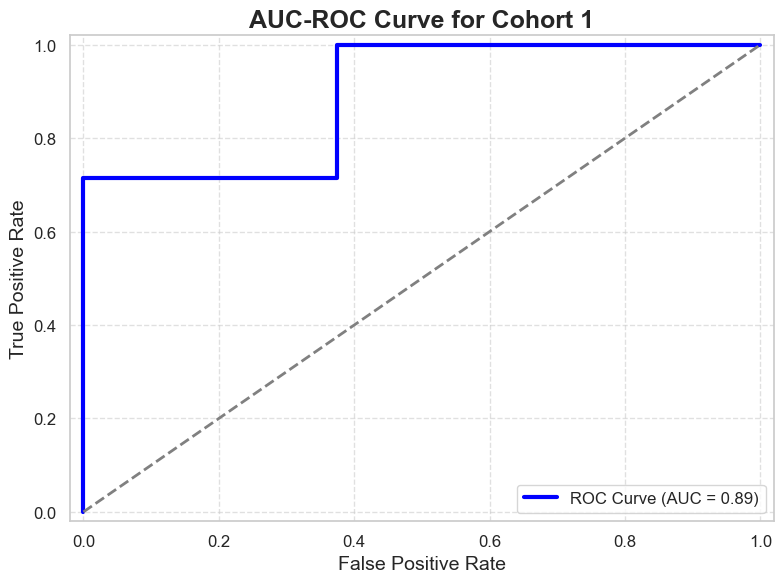

In [3]:
# plot ROC curve
y_test_proba = mlp_model.predict_proba(X_test_pca)[:, 1]
y_test_pred = (y_test_proba >= 0.92).astype(int) 
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba, pos_label=6.0)
roc_auc = auc(fpr, tpr)

# seaborn
sns.set(style='whitegrid')

# Plot ROC curve
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', lw=3, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('AUC-ROC Curve for Cohort 1', fontsize=18, fontweight='bold')
plt.legend(loc='lower right', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

# re-encoding labels (in the dataset, 0 is 1 and 1 is 6)
y_test_binary = (y_test == 6.0).astype(int)  # Re-encode 6.0 as 1 and 1.0 as 0
y_test_pred = (mlp_model.predict_proba(X_test_pca)[:, 1] >= 0.39).astype(int)


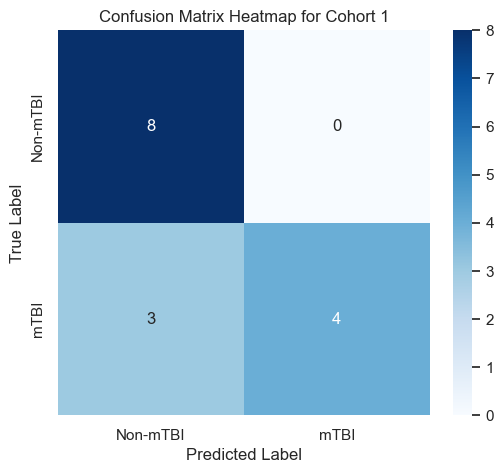

In [2]:
#confusion matrix
conf_matrix = confusion_matrix(y_test_binary, y_test_pred)

#confusion matrix heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels=['Non-mTBI', 'mTBI'], 
            yticklabels=['Non-mTBI', 'mTBI'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Heatmap for Cohort 1')
plt.show()